In [101]:
pip install river

In [102]:
pip install frouros

In [103]:
from river import datasets
from river import linear_model, tree
from river import drift, metrics
from river.datasets import synth
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [104]:
dataset = synth.FriedmanDrift(
    drift_type='gra',
    position=(2000,3000),
    seed=42)

# Initialize the data containers
data = []
for i, (x, y) in enumerate(dataset):
    x_values = list(x.values())
    data.append(x_values + [y])
    if i >=3000:  # Limiting to 5000 samples for simplicity
        break

In [105]:
# Define the column names
column_names = [f'x{i}' for i in range(1, len(x_values) + 1)] + ['y']

In [106]:
# Create the DataFrame
df = pd.DataFrame(data, columns=column_names)

In [107]:
train = df.iloc[:1000]
stream = df.iloc[1000:]

In [108]:
# Create the drift indicator list
drift_position = 1000

In [109]:
X =train.drop(columns='y').values
y = train['y'].values

In [110]:
# models
concept1 = LinearRegression()
concept2 = RandomForestRegressor()
concept3 = DecisionTreeRegressor()
concept4 = SVR()

In [111]:
from sklearn.pipeline import Pipeline

# Define and fit model
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", concept1),
    ]
)
pipeline.fit(X=X, y=y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [112]:
X_test = stream.drop(columns='y').values
y_test = stream['y'].values

In [113]:
X_test.shape

(2001, 10)

In [114]:
from frouros.detectors.concept_drift import PageHinkley, PageHinkleyConfig

In [115]:
# Detector configuration and instantiation
config = PageHinkleyConfig(
    lambda_ = 50.0,   # initially 50
    alpha = 0.7999,  # forgetting factor property, default to 0.9999
    min_num_instances = 30,  # minimum numbers of instances to start looking for changes, default to 30
    # delta is initially 0.005 i.e confidence value, default to 0.005
)
detector = PageHinkley(config=config)

In [116]:
detected_drifts = []
false_alarms = 0
detection_delays = []
y_preds = []
errors = []

In [117]:
from frouros.metrics import PrequentialError

# Metric to compute accuracy
metric = PrequentialError(alpha=0.9)  # alpha=1.0 is equivalent to normal accuracy

In [118]:
from sklearn.metrics import mean_squared_error

# isFirst = True

for i in range(len(X_test)):
    X_i = X_test[i].reshape(1, -1)
    y_i = y_test[i].reshape(1, -1)

    # Predict and calculate the error
    y_pred = pipeline.predict(X_i)
    y_preds.append(y_pred[0])
    error = mean_squared_error(y_true=y_i, y_pred=y_pred)
    metric_error = metric(error_value=error)
    # error = metric(error_value=mean_squared_error(y_true=y_i, y_pred=y_pred))
    errors.append(metric_error)

    # Update Page Hinkley with the error (0 for correct, 1 for incorrect)
    # detector.update(value=1 if error > 0 else 0)

    # Step 4: Update the drift detector with the current error
    detector.update(value=error)

    # Step 5: Check for detected drift
    if detector.drift:
        # print(f"Change detected at step {i}")
        detected_drifts.append(i)

        # Determine if it's a false alarm or not
        if i < drift_position:  # Compare with the original drift point
            false_alarms += 1
        else:
            #if isFirst:
                #isFirst = False
            detection_delays.append(i - drift_position)
        detector.reset()

    # Check for detected warning
    #if not warning_flag and detector.warning:
     #   print(f"Warning detected at step {i}")
      #  warning_flag = True


In [119]:
print(detection_delays)

[32, 75, 110, 196, 235, 265, 338, 400, 444, 489, 524, 585, 630, 670, 705, 754, 796, 848, 940, 993]


In [120]:
false_alarm_rate = (false_alarms / (len(X_test) - drift_position)) * 100 if detected_drifts else 0
detection_delay = (detection_delays[0]) if detection_delays else None
misDetection_rate = (len(detection_delays)-1)/(len(X_test) - drift_position) * 100 if detected_drifts else 0

In [121]:
print(f"Detected drift points: {detected_drifts}")
print(f"False alarms: {false_alarms}")
print(f"False alarm rate: {false_alarm_rate} %")
print(f"Detection delays at: {detection_delays} indices")
print(f"Detection delay at index: {detection_delay}")
print(f"Misdetection rate: {misDetection_rate} %")

Detected drift points: [81, 171, 275, 514, 557, 887, 999, 1032, 1075, 1110, 1196, 1235, 1265, 1338, 1400, 1444, 1489, 1524, 1585, 1630, 1670, 1705, 1754, 1796, 1848, 1940, 1993]
False alarms: 7
False alarm rate: 0.6993006993006993 %
Detection delays at: [32, 75, 110, 196, 235, 265, 338, 400, 444, 489, 524, 585, 630, 670, 705, 754, 796, 848, 940, 993] indices
Detection delay at index: 32
Misdetection rate: 1.898101898101898 %


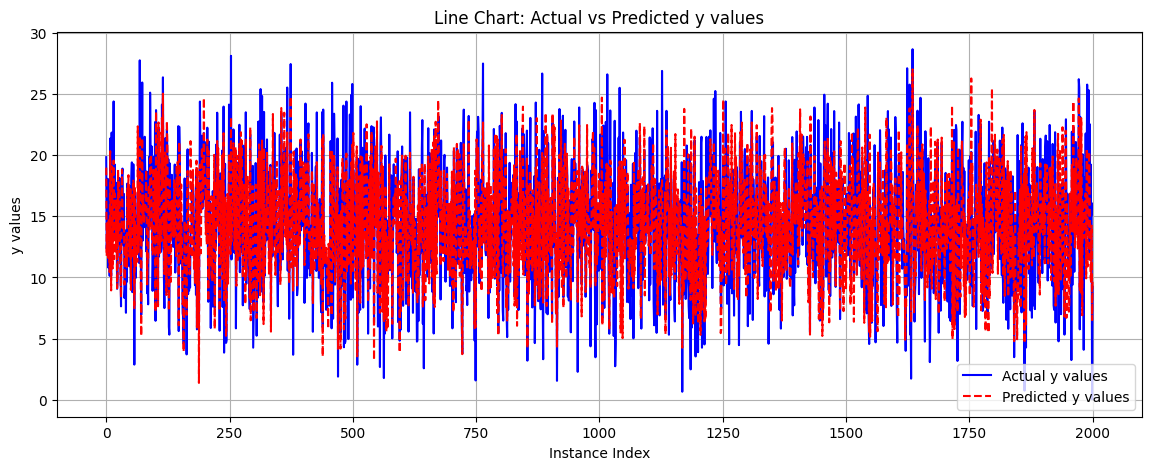

In [122]:
# Generate a line chart to compare actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_test)), y_test, label="Actual y values", color='blue', linestyle='-')
plt.plot(range(len(y_preds)), y_preds, label="Predicted y values", color='red', linestyle='--')
plt.xlabel("Instance Index")
plt.ylabel("y values")
plt.title("Line Chart: Actual vs Predicted y values")
plt.legend()
plt.grid(True)
plt.show()

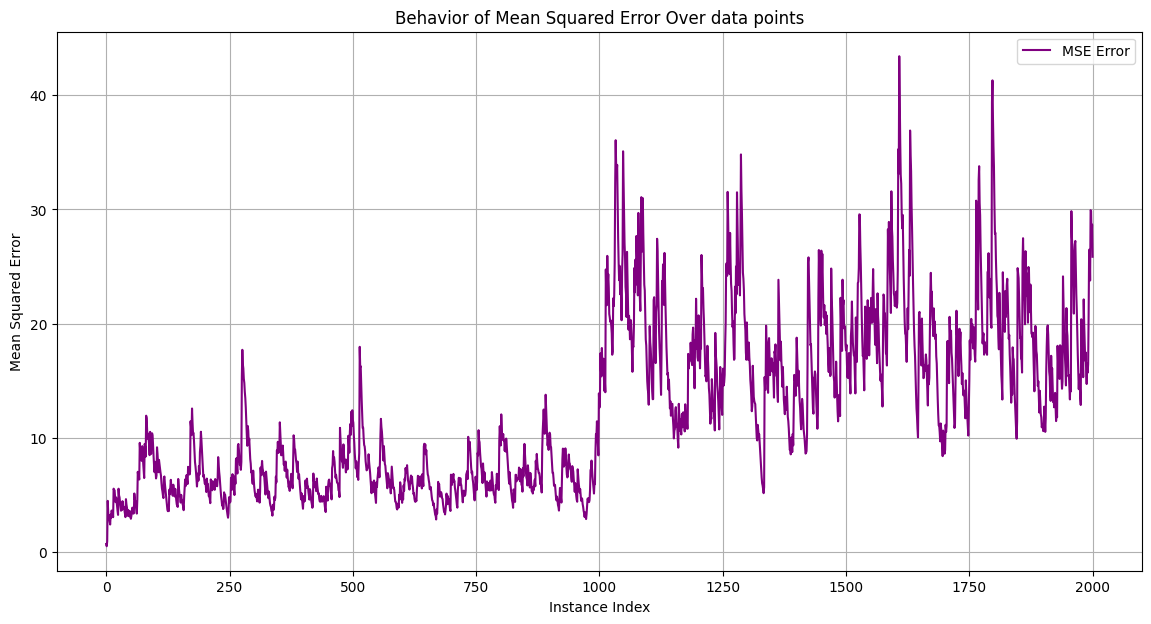

In [123]:
# Plotting the error values
plt.figure(figsize=(14, 7))
plt.plot(range(len(errors)), errors, label="MSE Error", color='purple')
plt.xlabel("Instance Index")
plt.ylabel("Mean Squared Error")
plt.title("Behavior of Mean Squared Error Over data points")
plt.legend()
plt.grid(True)
plt.show()

In [124]:
# binary array for initial drift
drift_indicator = np.zeros(len(data) - drift_position)
first_drift_found = False

for drift_point in detected_drifts:
    # Check if drift_point is at or after drift_position and if it's the first drift point after drift_position
    if drift_point < drift_position:
        # Set drift_indicator to 1 starting from the position of the first detected drift after drift_position
        drift_indicator[drift_point] = 1  # Fill from this index onward with 1s
    elif drift_point >= drift_position and not first_drift_found:
        drift_indicator[drift_point:] = 1  # Fill from this index onward with 1s
        first_drift_found = True
    else:
        continue

drift_creator = np.ones(len(data)-drift_position)
for i in range(drift_position,-1,-1):
    drift_creator[i] = 0

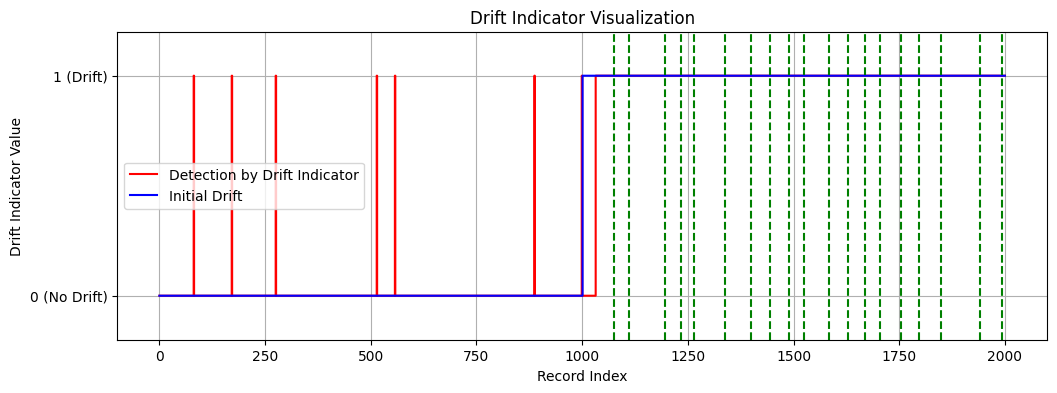

In [125]:
import matplotlib.pyplot as plt

# Visualize the drift indicator
plt.figure(figsize=(12, 4))
plt.plot(drift_indicator, drawstyle='steps-post', color='red', label='Detection by Drift Indicator')
plt.plot(drift_creator, drawstyle='steps-post', color='blue', label='Initial Drift')
for i in range(1,len(detection_delays)):
    plt.axvline(x=drift_position+detection_delays[i], color='green', linestyle='--') #label='mis-detection')
# plt.axvline(x=drift_position-1000, color='red', linestyle='--', label='Drift Point')

plt.title('Drift Indicator Visualization')
plt.xlabel('Record Index')
plt.ylabel('Drift Indicator Value')
plt.ylim(-0.2, 1.2)
plt.yticks([0, 1], labels=['0 (No Drift)', '1 (Drift)'])
plt.legend()
plt.grid(True)
plt.show()
